# **Postgresql**

- 오픈 소스 객체-관계형 데이터베이스 관리 시스템(ORDBMS)

- 클라이언트/서버 모델을 사용

- 프로세스 기반의 DBMS.

- 1개의 connection 마다 1개의 backend 프로세스 생성(Postmater 프로세스에 의해 fork).

- Autovacuumlauncher/worker 프로세스.

- 서버는 데이터베이스 파일들을 관리하며, 클라이언트 애플리케이션으로부터 들어오는 연결을 수용하고, 클라이언트를 대신하여 데이터베이스 액션을 수행.

- 서버는 다중 클라이언트 연결을 처리할 수 있는데, 서버는 클라이언트의 연결 요청이 오면 각 커넥션에 대해 새로운 프로세스를 fork하고 클라이언트는 기존 서버와의 간섭없이 새로 생성된 서버 프로세스와 통신하게 된다.

- postgresql의 database는 여러개의 schema로 구성되어 있으며 schema는 object들의 논리적 집합을 의미

- postgresql schema는 tables, views, sequences, synonyms, domains, functions등의 object로 구성되며 database와 users/groups와 tablespaces가 모여 cluster를 구성



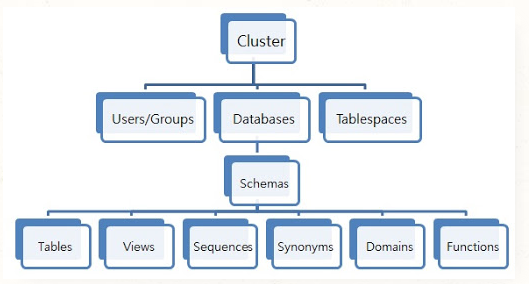

**Database**

- PostgreSQL은 여러 개의 데이터베이스로 구성. 이를 데이터베이스 클러스터라고 함.
- intidb() 수행 시에 template0, template1, postgres 데이터베이스가 생성.
- template0과 template1 데이터베이스는 사용자 데이터베이스 생성을 위한 템플릿 데이터베이스이며 시스템 카탈로그 테이블을 포함.
- initdb() 수행 직후에 template0 과 template1 데이터베이스의 테이블 목록은 같다.
  - template1의 데이터베이스에는 사용자가 필요한 오브젝트를 생성할 수 있다.
- 사용자 데이터베이스를 생성할 때 template1 데이터베이스를 복제.
 - 이점을 이용하면, 사용자 데이터베이스마다 특정한 오브젝트를 매번 생성하는 번거로움을 해결할 수 있다.

**Tablespace**

- initdb() 수행 직후 pg_default, pg_global Tablespace가 생성
- 테이블 생성 시 Tablespace를 지정하지 않으면 pg_default Tablespace에 저장
- 데이터 베이스 클러스터 레벨에서 관리되는 테이블을 pg_global Tablespace에 저장
- pg_default Tablespace의 물리적 위치는 PGDATA\tblspc
- pg_global Tablespace의 물리적 위치는 PGDATA\tblspc
- 1개의 Tablespace를 여러 개의 데이터베이스가 사용할 수 있다.
 - Tablespace 디렉토리 내에 Database별 서브 디렉토리가 생성.
 - 서브 디렉토리의 이름은 Database의 OID.
- 사용자 Tablespace를 생성하면 $PGDATA\tblspc 디렉토리에 사용자 Tablespace와 관련된 심볼릭 링크가 생성.



**Table**

- 테이블 별로 3개의 파일이 존재
  - 1개는 테이블 데이터를 저장하기 위한 파일, 파일명은 테이블 OID
  - 1개의 테이블 여유 공간을 관리하기 위한 파일, 파일명은 OID_fms
  - 1개는 테이블 블록의 visibility를 관리하기 위한 파일. 파일명은 OID_vm
- 인덱스는 vm 파일이 없음.[OID, OID_fsm 2개의 파일로 구성]

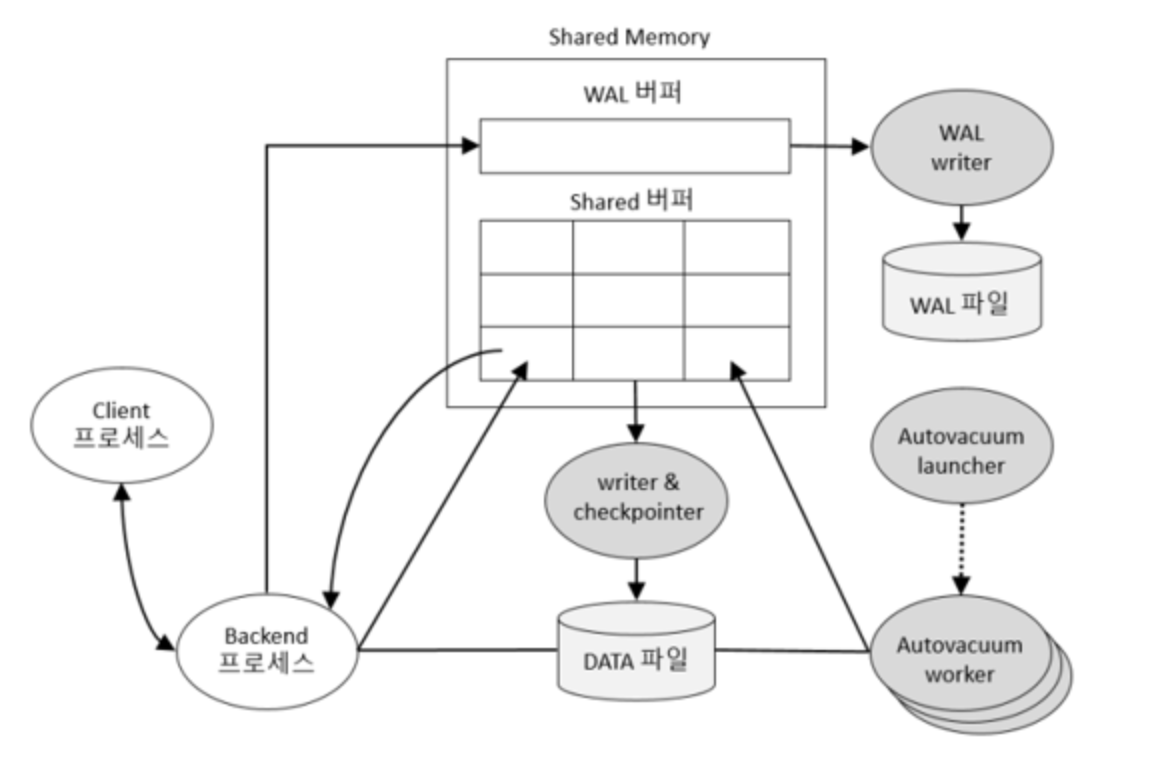

# **Shared Memory**

- Shared Memory는 트랜잭션 및 다른 로그 캐치용으로 할당 된 메모리로 Shared Buffers, WAL Buffers, Work Memory, Maintenance Work Memory로 구성.
- 설정은 Postgresql의 data 폴더의 postgresql.conf 파일에서 설정 가능.

**Shared Buffers**

- PostgreSQL도 다른 RDBMS와 같이 데이터베이스에 엑세스를 시도하면, 디스크에서 필요한 데이터를 공유 버퍼로 먼저 읽어 들인다.(Oracle의 SGA와 같은 개념)
- 공유 버퍼에서 데이터를 읽고, 쓰기를 처리한다. 이후, 동일한 데이터 엑세스에 대해서는 공유버퍼에서 읽어 들여, 느린 디스크 엑세스를 줄여 성능을 확보 할 수 있는 기본적인 튜닝.
- 기본 값은 128MB 이며, 최소 128KB 이상으로 설정하여야 한다.
- shared_buffers 설정은 서버 메모리의 1/4 또는 1/2정도. (공식 페이지에서는 40%를 넘지 않도록 권장.)
- 설정값은 MB, GB 등 단위별로 설정 가능.
- 이렇게 Shared Buffers 메모리를 사용하는 이유는 Disk I/O를 최소하 하기 위해서 사용.

**WAL Buffers**

- 데이터를 업데이트 할 때 어떤 변경을 할 것 인지를 남기는 로그이며, PostgreSQL에서는 WAL(Write Ahead Log)이라 명칭함 손실된 데이터 복원 역할.
- config파일에서 wal_buffers 값 변경, 일반적으로 shared_buffers의 1/32 크기로 지정.
- WAL(Write Ahead Logging) Buffer의 변경사항이 WAL 파일로 작성되는데 이 WAL 파일을 StandBy 서버에 전송하는 방식을 이용하여 Posgresql HA 구성을 할 수있다.

**Work Memory**
- 내부 정렬 및 해시 테이블에 사용항 메모리 양을 설정.
= 정렬 작업은 ORDER BY, DISTINCT 및 병합 조인에 사용되고 해시 테이블은 해시 조인, 해시 기반 집계 및 IN 하위 쿼리의 해시 기반 처리에 사용.
- 기본값은 4MB.
- 여러 세션이 병렬로 메모리를 사용할 수 있으므로 전체 메모리는 설정한 값의 몇배가 될 수 있다.
- work_mem의 설정은 1 / (max_connections * 2)으로 설정하는 것이 적당.
  - 예를들어 1GB의 서버 메모리에 max_connections가 100이면 1024/200 = 5.12로 약 5MB로 설정하면 된다.
  - 설정을 튜닝한다고 이 메모리를 무작정 늘리게되면 out of memory 오류가 발생.

**Maintenance Work Memory**
- VACUUM, ANALYZE, ALTER TABLE, CREATE INDEX 및 ADD FOREIGN KEY 등과 같은 데이터베이스 유지 관리 작업을위한 메모리.
- 9.3 및 이전 버전의 Maintenance Work Memory의 기본값은 9.4에서 16MB (16MB)이고 이후 Maintenance Work Memory의 기본값은 64MB.
- Work Memory에 비해 큰 Maintenance Work Memory를 설정하는 것이 안전.
- 설정이 클수록 유지 관리 (VACUUM, ANALYZE, ALTER TABLE, CREATE INDEX 및 ADD FOREIGN KEY 등) 작업의 성능이 향상됨.



```md
- VACCUM은 Postgresql MVCC를 구현하기 위한 방법으로 데이터를 UPDATE 또는 DELETE시에 디스크에 있던 기존 정보를 갱신하거나 삭제하지 않고 기존 정보는 변경되었다는 표시를 남기고 새롭게 디스크에 UPDATE된 정보를 기록
- 이 과정에서 DELETE 했어도 디스크 용량은 줄어들지 않으며 UPDATE 시에는 새로운 행이 추가되기 때문에 디스크 용량이 증가한다 이때 이 낭비된 공간을 제거해주는 명령어가 VACCUM.
```





# **Background Processes**

**Postmaster Processes**

- 제일 앞단에서 Client와 맞닫는 프로세스.

- PostgreSQL 기동할 때 가장 먼저 시작되는 프로세스.

- 초기 복구 작업, 메모리 초기화, Background 프로세스 기동작업 수행.

- 데몬 프로세스로 Client 프로세스의 접속 요청을 받아 Backend 프로세스를 생성.

**Background Processes**

- 로그, 통계 등 백그라운드에서 배치성으로 돌아가는 프로세스.

 - logger : 에러 메시지를 로그 파일에 기록.
 - checkpointer : 체크 포인트 발생시 dirty 버퍼를 데이터파일에 기록.
 - Background writer : 로그 및 백업 정보를 최신 상태로 유지.
 - wal writer : WAL 버퍼를 WAL 파일에 기록.
 - autovacuum launcher : Vacuum 이 필요한 시점에 Postmaster 프로세스에 autovacuum worker 프로세스 기동 요청.
 - archiver : Archive mode 사용시 WAL 파일을 지정된 디렉토리로 복사.
 - stats collector 세션 수행 정보, 테이블 사용 통계 정보 같은 DBMS 통계 정보 수집.

**Backend Processes**
- Backend 프로세스의 최대 개수는 max_connections 파라미터로 설정 가능하며, 기본값은 100
- Backend 프로세스는 사용자 프로세스의 쿼리 요청을 수행한 후, 결과를 전송하는 역할을 수행[Backend 사용자와 연결에 할당되는 Backend Process]
- 쿼리 수행에 몇가지 메모리 구조가 필요한데, 이 것을 통칭해서 로컬 메모리라고 함
- 로컬 메모리 관련 주요 파라미터
   - work_mem: 정렬 작업, Bitmap 작업, 해시 조인과 Merge조인 작업시에 사용되는 공간. 기본값은 4MB
   - maintenance_work_mem: Vacuum 및 create index 작업 시에 사용되는 공간. 기본값은 64MB
   - temp_buffers: Temporary 테이블을 저장하기 위한 공간. 기본값은 8MB


**Client Processes**

- 사용자가 PostgreSQL에 접속하기 위해 사용하는 모든 응용프로그램
- 사용자의 OS환경과 취향에 따라 여러 프로그램이 가능

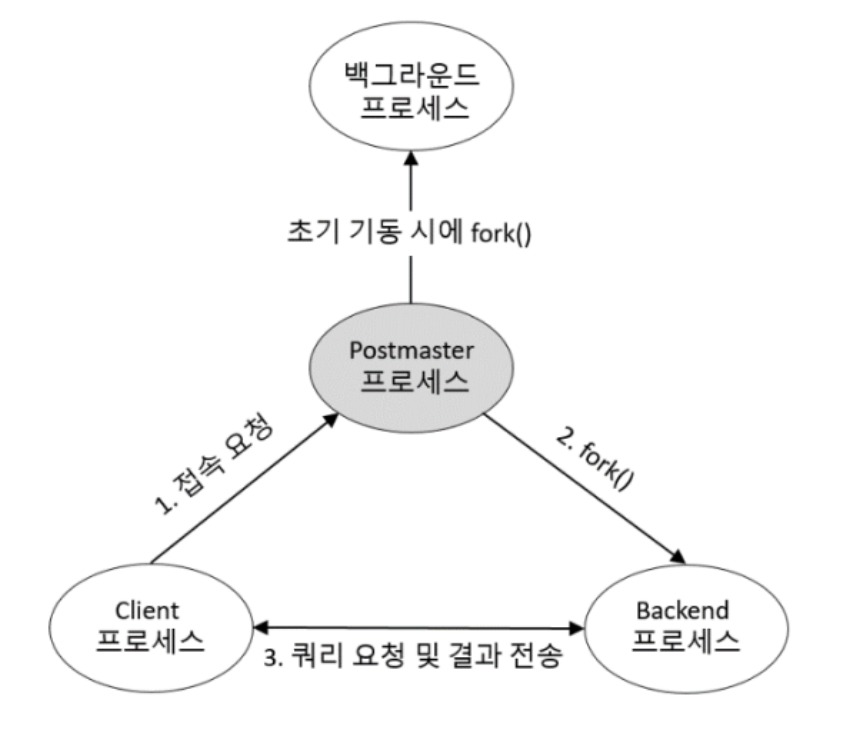

# **Data directory structure / Data files**

- PostgreSQL은 데이터베이스 Cluster(Cluster는 하나의 서버 인스턴스에 의해 관리되는 여러 Database의 모음)라고 불리는 여러 데이터베이스로 구성.
- Postgre를 초기화할 때SQL 데이터베이스 template0, template1 및 Postgres 데이터베이스가 생성됨 Template0 및 Template1은 시스템 카탈로그 테이블을 포함하는 새로운 데이터베이스 사용자 작성을 위한 템플리트 데이터베이스.
- 사용자 데이터베이스는 template1 데이터베이스를 복제하여 생성.


```md

Template 데이터베이스

- PostgreSQL에서 "Create Database"로  테이블을 생성할 때, 기본으로 생성되어 있는 Template1 Database를 복사하여 생성.
- Template Database는 표준 시스템 데이터베이스로 원본 데이터베이스에 해당하는데 template1에서 프로시저언어 PL/Perl을 설치하는 경우 해당 데이터베이스를 생성할 때 추가적인 작업 없이 사용자 데이터베이스가 자동으로 사용 가능

- PostgresQL에는 Template0라는 2차 표준 시스템 데이터베이스가 있는데, 이 데이터베이스에는 template1의 초기 내용과 동일한 데이터가 포함.
- Template 0은 수정하지 않고 원본 그대로 유지하여 무수정 상태의 데이터베이스를 생성할 수 있으며, pg_dump 덤프를 복원할 때 유용하게 사용.


```


**Cluster에 대한 구분 3가지**

- Data directory
- TCP Port
- Set of processes

<br>

PGDATA 디렉터리에는 여러 하위 디렉터리가 포함되어 있으며 제어 파일은 다음과 같다.

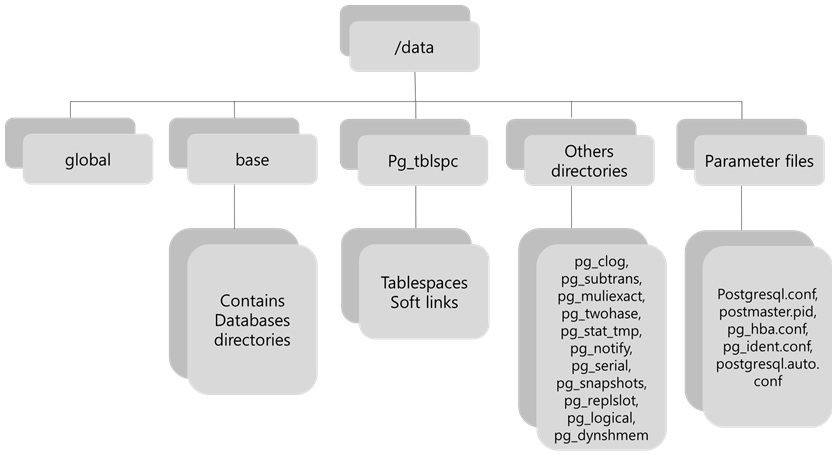

- pg_version : 데이터베이스 버전 정보를 포함.
- base : 데이터베이스 하위 디렉토리를 포함.
- global : pg_user와 같은 클러스터 현명한 테이블 포함.
- pg_clog : 트랜잭션 포함은 상태 데이터를 커밋.
- pg_multixact : 다중 트랜잭션 상태 데이터 포함 (공유 행 잠금에 사용됨).
- pg_notify : LISTEN / NOTIFY 상태 데이터 포함.
- pg_serial : 커밋 된 직렬화 가능한 트랜잭션에 대한 정보 포함.
- pg_snapshots : 내 보낸 스냅 샷 포함.
- pg_stat_tmp : 통계 서브 시스템을위한 임시 파일을 포함.
- pg_subtrans : 하위 트랜잭션 상태 데이터 포함.
- pg_tblspc : 테이블 스페이스에 대한 심볼릭 링크 포함.
- pg_twophase : 준비된 트랜잭션을위한 상태 파일 포함.
- pg_xlog : WAL (Write Ahead Log) 파일 포함.
- pid : 현재 포스트 마스터 프로세스 ID (PID)를 포함하는 파일.

# **내부 구조**

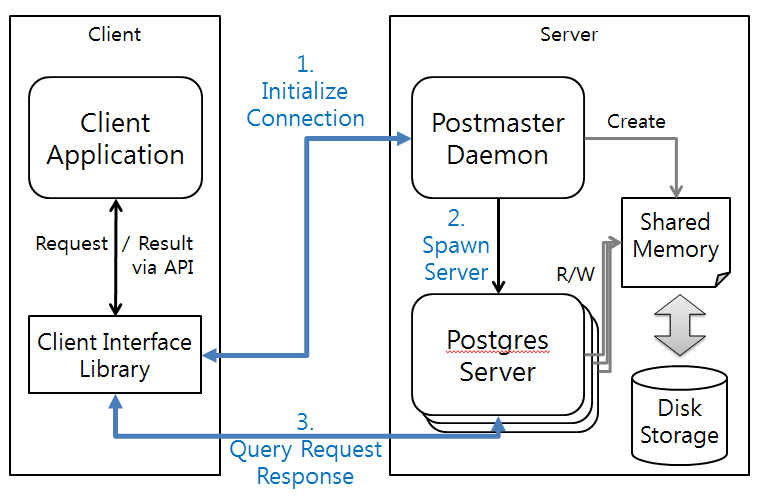

1. 클라이언트는 인터페이스 라이브러리(libpg, JDBC, ODBC 등의 다양한 인터페이스)를 통해 서버와의 연결을 요청
2. Postmaster 프로세스가 서버와의 연결을 중계.
3. 이후 클라이언트는 할당된 서버와의 연결을 통해 질의를 수행

**서버 내부의 질의 수행 과정**

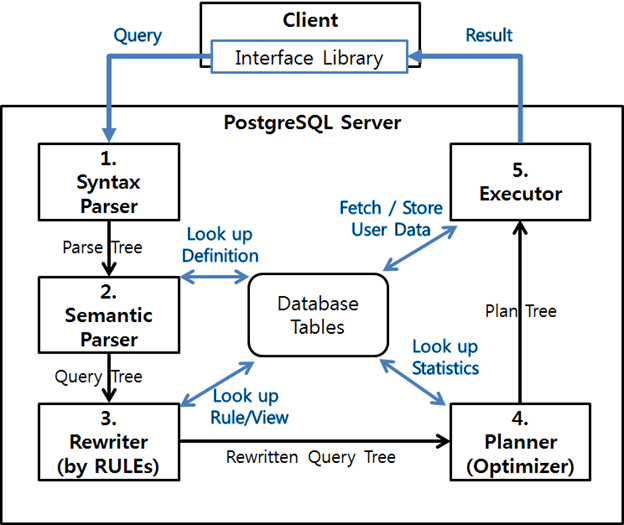

1. 클라이언트로부터 질의 요청이 들어오면 구문 분석 과정을 통해 Parse Tree를 생성하고 의미 분석 과정를 통해 새로운 트랜잭션을 시작하고 Query Tree를 생성.
2. 이후 서버에 정의된 Rule에 따라 Query Tree가 재 생성되고 실행 가능한 여러 수행 계획 중 가장 최적화된 Plan Tree를 생성.
3. 서버는 이를 수행하여 요청된 질의에 대한 결과를 클라이언트로 전달

- 서버의 쿼리 수행 과정에서는 데이터베이스 내부의 시스템 카탈로그가 많이 사용되는데, 사용자가 함수나 데이터 타입은 물론 인덱스 접근 방식 및 RULE 등을 시스템 카탈로그에 직접 정의할 수도 있다.
- PostgreSQL에서는 이것이 기능을 새로 추가하거나 확장하는데 있어 중요한 포인트로 활용

- 데이터가 저장되는 파일들은 여러 개의 페이지들로 구성되며, 하나의 페이지는 확장 가능한 slotted page 구조를 가진다

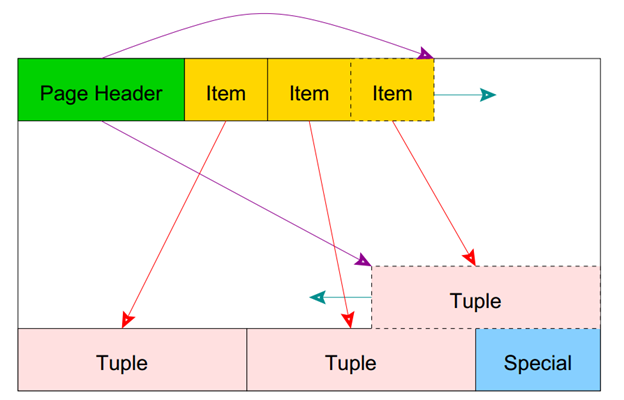

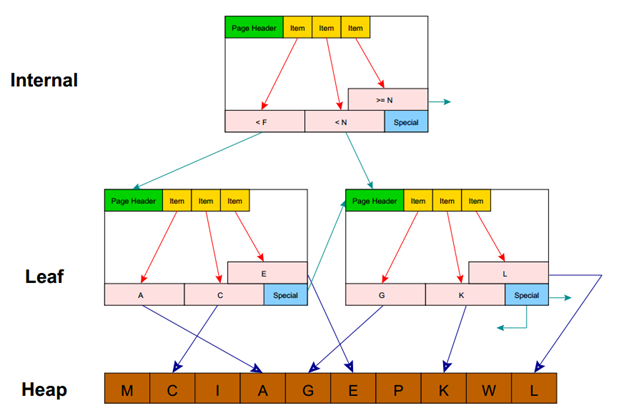